## Pre-processing of CSV files

In [ ]:
import pandas as pd
import re
import string

def load_data(file_paths, encodings=['utf-8', 'ISO-8859-1']):
    dataframes = []
    for file_path in file_paths:
        for encoding in encodings:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                dataframes.append(df)
                print(f"Successfully loaded {file_path} with encoding {encoding}. Shape: {df.shape}")
                break  # Exit the loop if reading is successful
            except UnicodeDecodeError:
                continue  # Try the next encoding if there's an error
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"Combined DataFrame shape: {combined_df.shape}")
    return combined_df

def clean_text(text):
    if pd.isnull(text):
        return ''
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)  # Remove punctuation
    text = re.sub(r'[^\x00-\x7F]+', '', text)  # Remove non-ASCII characters
    return text.strip()

def preprocess_dataframe(df):
    print(f"DataFrame shape before dropping NaNs: {df.shape}")
    df.dropna(inplace=True)  # Remove empty rows
    print(f"DataFrame shape after dropping NaNs: {df.shape}")
    df['concerns'] = df['concerns'].apply(clean_text)
    df['anything else'] = df['anything else'].apply(clean_text)
    return df

file_paths = ['data_file_1_02.csv', 'data_file_2_08.csv', 'data_file_3_08.csv']
df = load_data(file_paths)
df = preprocess_dataframe(df)

# Encode labels
label_mapping = {'AC': 0, 'PC': 1, 'TC': 2, 'NC': 3}
df['concerns category'] = df['concerns category'].map(label_mapping)
df['anything else category'] = df['anything else category'].map(label_mapping)

# Create combined text and category columns
concerns_df = df[['concerns', 'concerns category']].rename(columns={'concerns': 'combined_text', 'concerns category': 'combined_category'})
anything_else_df = df[['anything else', 'anything else category']].rename(columns={'anything else': 'combined_text', 'anything else category': 'combined_category'})

# Concatenate both dataframes
final_df = pd.concat([concerns_df, anything_else_df], ignore_index=True)

# Save the final cleaned dataset
final_df.to_csv('cleaned_data.csv', index=False)

print(f"Final DataFrame shape: {df.shape}")

Successfully loaded data_file_1_02.csv with encoding ISO-8859-1. Shape: (1279, 4)
Successfully loaded data_file_2_08.csv with encoding ISO-8859-1. Shape: (718, 4)
Successfully loaded data_file_3_08.csv with encoding ISO-8859-1. Shape: (621, 4)
Combined DataFrame shape: (2618, 4)
DataFrame shape before dropping NaNs: (2618, 4)
DataFrame shape after dropping NaNs: (1324, 4)
Final DataFrame shape: (1324, 4)


## BERT Training model

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.nn.functional import softmax
from tqdm import tqdm

# Load data
df = pd.read_csv('cleaned_data.csv')

# Tokenize text and encode labels
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_data = tokenizer(df['combined_text'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
labels = torch.tensor(df['combined_category'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['combined_category'].unique()))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Average Epoch Loss: {avg_epoch_loss:.4f}")

# Evaluation loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(input_ids=inputs)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

# Save the model to a file
model.save_pretrained('bert_model')
tokenizer.save_pretrained('bert_model')

# Load the model from the file
loaded_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['combined_category'].unique()))
loaded_model.load_state_dict(torch.load('bert_model/pth'))
loaded_model.eval()  # Set the model to evaluation model

# Example text for evaluation
text = "I'm concerned about not remembering stuff from calc"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Forward pass through the model
with torch.no_grad():
    outputs = loaded_model(**inputs)

# Get predicted probabilities
probs = softmax(outputs.logits, dim=1)

# Get the predicted class
predicted_class = torch.argmax(probs, dim=1).item()

# Print the results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probs.tolist()}")


## Original Code

In [ ]:
!pip install tiktoken

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 6.8 MB/s eta 0:00:00


In [ ]:
import typing
from typing import List, Tuple

import tiktoken
import ast

import pandas as pd
import time

In [ ]:
def read_list_from_file(file_path):
    try:
        with open(file_path, 'r') as file:
            # Read the file content as a string
            file_content_str = file.read()

            # Safely evaluate the string as a Python literal (list)
            file_contents = ast.literal_eval(file_content_str)

        return file_contents

    except FileNotFoundError:
        print(f"The file '{file_path}' does not exist.")
    except (SyntaxError, ValueError) as e:
        print(f"Error while evaluating the file content: {e}")
    except Exception as e:
        print(f"An error occurred: {e}")

def df_from_file(file_path):
    listy = read_list_from_file(file_path)
    category = file_path.replace(".txt", "")
    df = pd.DataFrame({'response': listy, 'category': [category] * len(listy)})
    return df

#Files is a list of files to add it from. Put it all in one dataframe
def multiple_df(files):
    dfs = []
    for file in files:
        dfs.append(df_from_file(file))

    result_df = pd.concat(dfs, ignore_index=True)
    return result_df


ret = multiple_df(["AC.txt", "PC.txt", "TC.txt", "NC.txt"])
shuffled_df = ret.sample(frac=1).reset_index(drop=True)
shuffled_df

,response,category
0,I have no concerns.,NC
1,I enjoy when you explain a concept from multip...,NC
2,I will not understand the course material thor...,AC
3,I'm a little concerned about not being able to...,AC
4,I am most concerned about not understanding th...,AC
...,...,...
3284,none,NC
3285,There is nothing I would like to share.,NC
3286,none,NC
3287,One concern I have is keeping up with my work ...,PC


In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import pandas as pd
from transformers import TFAutoModel, BertTokenizer

import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn.functional import softmax

In [ ]:
#Loads my tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
#Loads my data frame
df = shuffled_df

#Puts my data frame in a good format for ML
#Max length is 512
#encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
#labels = torch.tensor(df['category'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
shuffled_df

# Define a mapping dictionary
category_mapping = {'AC': 0, 'PC': 1, 'TC': 2, 'NC': 3}

# Apply the mapping using the map function
shuffled_df['category_int'] = df['category'].map(category_mapping)
shuffled_df

,response,category,category_int
0,I have no concerns.,NC,3
1,I enjoy when you explain a concept from multip...,NC,3
2,I will not understand the course material thor...,AC,0
3,I'm a little concerned about not being able to...,AC,0
4,I am most concerned about not understanding th...,AC,0
...,...,...,...
3284,none,NC,3
3285,There is nothing I would like to share.,NC,3
3286,none,NC,3
3287,One concern I have is keeping up with my work ...,PC,1


In [ ]:
# Load your DataFrame
df = shuffled_df

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tokenize text and encode labels
encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')  # Reduced max_length for speed
labels = torch.tensor(df['category_int'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load pre-trained BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(df['category_int'].unique()))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 3
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_loss = 0
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        epoch_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    print(f"Average Epoch Loss: {avg_epoch_loss:.4f}")

# Evaluation loop (optional)
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for batch in test_dataloader:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(input_ids=inputs)
        _, predicted = torch.max(outputs.logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3


100%|██████████| 165/165 [00:53<00:00,  3.08it/s]


Average Epoch Loss: 0.8110
Epoch 2/3


100%|██████████| 165/165 [00:53<00:00,  3.07it/s]


Average Epoch Loss: 0.5020
Epoch 3/3


100%|██████████| 165/165 [00:55<00:00,  2.98it/s]

Average Epoch Loss: 0.3283


Test Accuracy: 0.8389


In [ ]:
# Save the model to a file
torch.save(model.state_dict(), 'bert_model.pth')

# Load the model from the file
loaded_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
loaded_model.load_state_dict(torch.load('bert_model.pth'))
loaded_model.eval()  # Set the model to evaluation model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
import torch
from torch.nn.functional import softmax

# Example text for evaluation
text = "I'm concerned about not remembering stuff from calc"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

# Move inputs to the same device as the model (assuming model is on cuda:0)
inputs = {k: v.to("cuda:0") for k, v in inputs.items()}

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities (you may need to adjust this based on your specific task)
probs = softmax(outputs.logits, dim=1)

# Get the predicted class
predicted_class = torch.argmax(probs, dim=1).item()

# Print the results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probs.tolist()}")


Predicted class: 0
Class probabilities: [[0.6236473321914673, 0.3279206454753876, 0.030386406928300858, 0.018045563250780106]]


## Modification using tensorboard

Epoch 1/5


100%|██████████| 165/165 [00:55<00:00,  2.98it/s]

Average Train Loss: 0.0530


Average Test Loss: 0.6845
Test Accuracy: 0.8176
Epoch 2/5


100%|██████████| 165/165 [00:56<00:00,  2.90it/s]

Average Train Loss: 0.0760


Average Test Loss: 0.6701
Test Accuracy: 0.8313
Epoch 3/5


100%|██████████| 165/165 [00:57<00:00,  2.88it/s]

Average Train Loss: 0.0368


Average Test Loss: 0.6817
Test Accuracy: 0.8343
Epoch 4/5


100%|██████████| 165/165 [00:57<00:00,  2.88it/s]

Average Train Loss: 0.0128


Average Test Loss: 0.7993
Test Accuracy: 0.8298
Epoch 5/5


100%|██████████| 165/165 [00:56<00:00,  2.90it/s]

Average Train Loss: 0.0161


Average Test Loss: 0.7665
Test Accuracy: 0.8343


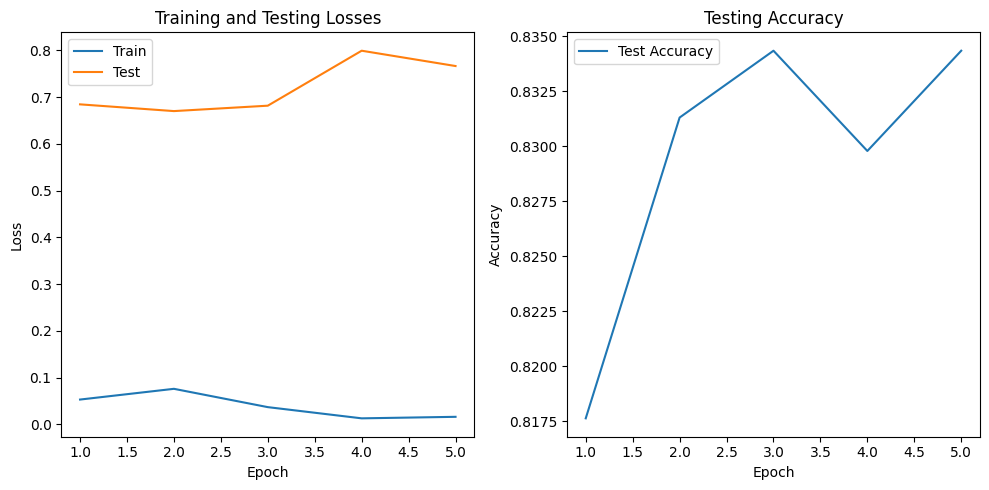

In [ ]:
import matplotlib.pyplot as plt
num_epochs = 5
# Lists to store training and testing metrics
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_train_loss = 0
    model.train()
    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average Train Loss: {avg_train_loss:.4f}")

    # Evaluation on test set
    model.eval()
    epoch_test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(input_ids=inputs)
            loss = criterion(outputs.logits, labels)
            epoch_test_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_test_loss = epoch_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting the training and testing curves
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## BERT Tiny

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 1/8


100%|██████████| 338/338 [02:12<00:00,  2.55it/s]

Average Train Loss: 1.2402


Average Test Loss: 0.9604
Test Accuracy: 0.7112
Epoch 2/8


100%|██████████| 338/338 [01:37<00:00,  3.46it/s]

Average Train Loss: 0.9692


Average Test Loss: 0.7184
Test Accuracy: 0.7660
Epoch 3/8


100%|██████████| 338/338 [01:29<00:00,  3.76it/s]


Average Train Loss: 0.8610
Average Test Loss: 0.6183
Test Accuracy: 0.7827
Epoch 4/8


100%|██████████| 338/338 [01:32<00:00,  3.67it/s]

Average Train Loss: 0.7909


Average Test Loss: 0.5711
Test Accuracy: 0.7888
Epoch 5/8


100%|██████████| 338/338 [01:37<00:00,  3.48it/s]

Average Train Loss: 0.7192


Average Test Loss: 0.5517
Test Accuracy: 0.7994
Epoch 6/8


100%|██████████| 338/338 [01:36<00:00,  3.50it/s]

Average Train Loss: 0.6181


Average Test Loss: 0.5422
Test Accuracy: 0.7979
Epoch 7/8


100%|██████████| 338/338 [01:31<00:00,  3.71it/s]

Average Train Loss: 0.4913


Average Test Loss: 0.5352
Test Accuracy: 0.8085
Epoch 8/8


100%|██████████| 338/338 [01:36<00:00,  3.50it/s]

Average Train Loss: 0.3660


Average Test Loss: 0.5847
Test Accuracy: 0.7796


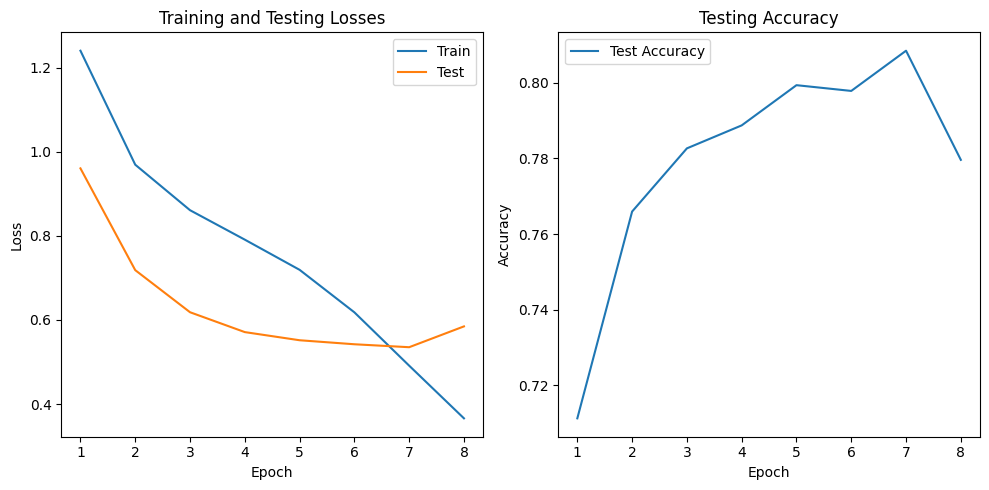

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load your dataset and shuffle if needed
# Assuming shuffled_df contains your data

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")
model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=4)

# Tokenize text and encode labels
encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
labels = torch.tensor(df['category_int'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)


# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
train_texts_np = train_texts.numpy()
train_labels_np = train_labels.numpy()
train_texts_resampled, train_labels_resampled = smote.fit_resample(train_texts_np, train_labels_np)

# Convert resampled data back to tensors
train_texts_resampled = torch.tensor(train_texts_resampled)
train_labels_resampled = torch.tensor(train_labels_resampled)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts_resampled, train_labels_resampled)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 8
train_losses = []
test_losses = []
test_accuracies = []

model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_train_loss = 0

    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average Train Loss: {avg_train_loss:.4f}")

    # Evaluation on test set
    model.eval()
    epoch_test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(input_ids=inputs)
            loss = criterion(outputs.logits, labels)
            epoch_test_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_test_loss = epoch_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting the training and testing curves
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Save the model to a file
torch.save(model.state_dict(), 'bert_model_small.pth')

In [ ]:
# Load the model from the file
loaded_model = BertForSequenceClassification.from_pretrained('prajjwal1/bert-tiny', num_labels=4)
loaded_model.load_state_dict(torch.load('bert_model_small.pth'))
loaded_model.eval()  # Set the model to evaluation model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-1

In [ ]:
import torch
from torch.nn.functional import softmax

# Example text for evaluation
text = "i have to go to celebrate a festival and have clashes with the class schedule"

# Tokenize and encode the text
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)

# Move inputs to the same device as the model (assuming model is on CPU)
inputs = {k: v.to("cpu") for k, v in inputs.items()}

# Ensure the model is also on the CPU
model.to("cpu")

# Forward pass through the model
with torch.no_grad():
    outputs = model(**inputs)

# Get predicted probabilities (you may need to adjust this based on your specific task)
probs = softmax(outputs.logits, dim=1)

# Get the predicted class
predicted_class = torch.argmax(probs, dim=1).item()

# Print the results
print(f"Predicted class: {predicted_class}")
print(f"Class probabilities: {probs.tolist()}")


Predicted class: 2
Class probabilities: [[0.10515139997005463, 0.2720135450363159, 0.5526778101921082, 0.07015722244977951]]


### SAND

Epoch 1/5


100%|██████████| 165/165 [00:55<00:00,  2.99it/s]

Average Train Loss: 0.9101


Average Test Loss: 0.6170
Test Accuracy: 0.7766
Epoch 2/5


100%|██████████| 165/165 [00:55<00:00,  2.97it/s]

Average Train Loss: 0.5018


Average Test Loss: 0.4504
Test Accuracy: 0.8313
Epoch 3/5


100%|██████████| 165/165 [00:56<00:00,  2.93it/s]

Average Train Loss: 0.2886


Average Test Loss: 0.4903
Test Accuracy: 0.8176
Epoch 4/5


100%|██████████| 165/165 [00:56<00:00,  2.94it/s]

Average Train Loss: 0.1227


Average Test Loss: 0.5808
Test Accuracy: 0.8298
Epoch 5/5


100%|██████████| 165/165 [00:56<00:00,  2.94it/s]

Average Train Loss: 0.0372


Average Test Loss: 0.7339
Test Accuracy: 0.8267


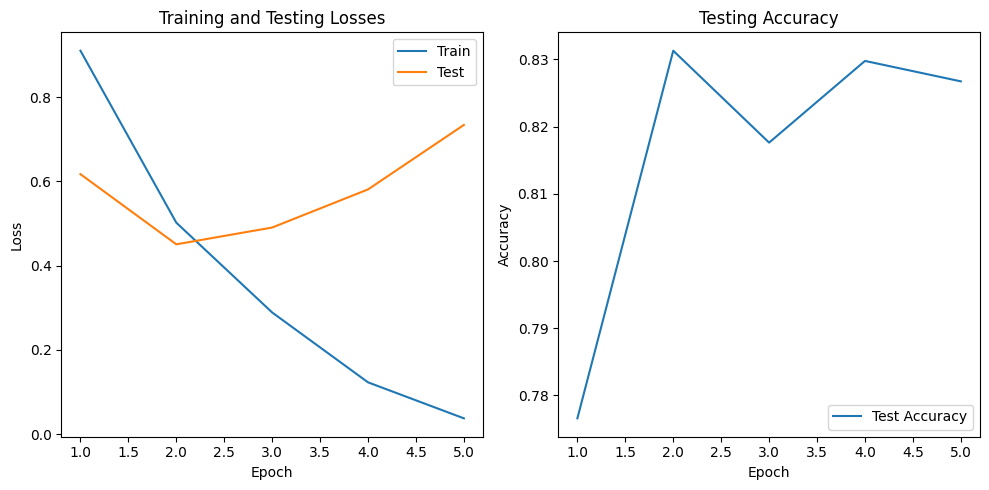

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load your dataset and shuffle if needed
# Assuming shuffled_df contains your data

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("NCHS/SANDS")
model = AutoModelForSequenceClassification.from_pretrained("NCHS/SANDS")

# Tokenize text and encode labels
encoded_data = tokenizer(df['response'].tolist(), padding=True, truncation=True, max_length=128, return_tensors='pt')
labels = torch.tensor(df['category_int'].tolist())

# Train-Test Split
train_texts, test_texts, train_labels, test_labels = train_test_split(encoded_data['input_ids'],
                                                                     labels,
                                                                     test_size=0.2,
                                                                     random_state=42)

# Create DataLoader for training
train_dataset = TensorDataset(train_texts, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)

# Create DataLoader for testing
test_dataset = TensorDataset(test_texts, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

# Training loop
num_epochs = 5
train_losses = []
test_losses = []
test_accuracies = []

# Fine-tune the output layer
model.train()
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_train_loss = 0

    for batch in tqdm(train_dataloader):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=inputs, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average Train Loss: {avg_train_loss:.4f}")

    # Evaluation on test set
    model.eval()
    epoch_test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in test_dataloader:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(input_ids=inputs)
            loss = criterion(outputs.logits, labels)
            epoch_test_loss += loss.item()

            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        avg_test_loss = epoch_test_loss / len(test_dataloader)
        test_losses.append(avg_test_loss)

        test_accuracy = correct / total
        test_accuracies.append(test_accuracy)
        print(f"Average Test Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting the training and testing curves
plt.figure(figsize=(10, 5))

# Plotting losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test')
plt.title('Training and Testing Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
